In [1]:
import time
import os
import random
import numpy as np                                                
import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg    
                                                     
import gym
# from gym import spaces
from gymnasium import spaces
import gymnasium 

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

In [2]:
# !pip3 install --upgrade stable_baselines3
# !pip3 install gym==0.22.0 

The below code is my RL extension to and rework of https://www.researchgate.net/publication/360698153_A_Tutorial_on_Structural_Optimization 
and
https://www.sciencedirect.com/science/article/pii/S0264127522002933

In [3]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=7, height=7, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

In [4]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [5]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [6]:
# @autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
# autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [7]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [8]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [9]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [10]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

# @autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

# autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
#                        lambda: print('err: gradient undefined'),
#                        lambda: print('err: gradient not implemented'))

In [11]:
class Model:
    def __init__(self, x):
        self.flag_ = True
#         self.flag_ = False
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1
        
    def draw(self,X):  
        plt.figure(dpi=50) 
        print('\nFinal Cantilever beam design:')
        plt.imshow(X) 
        plt.show()

In [12]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [13]:
class CantileverEnv(gym.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        
        
        self.rd=0
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        DIM=self.args.nelx*self.args.nely
        N_DISCRETE_ACTIONS=self.args.nelx*self.args.nely
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
#         self.seed=0
        
    def step(self, action):
        
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        self.M.action_space_(action, self.x)
        
        self.tmp, self.const = fast_stopt(self.args, self.x)
#         print(tmp, const)
        
        self.step_+=1
        
#         self.reward+=(1/self.tmp)**2
#         self.reward=(1/self.tmp)**2
        self.reward +=(1/self.tmp)**0.5

       
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        if self.const>0.7:
#             self.reward-=1
            done=True
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
      
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done,False, dict()

    def reset(self, seed=0):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        self.M.draw(self.x)    

    def close(self):
        pass

In [14]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [15]:
# ts=5e6
ts=7e6

In [16]:
# Create log dir
log_dir = "/tmp/gym6/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = CantileverEnv()
# Logs will be saved in log_dir/monitor.csv

env = Monitor(env, log_dir)
check_env(env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [17]:
# callback = SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [18]:
start=time.time()
model = PPO("MlpPolicy", env).learn(total_timesteps=ts, callback=callback)
end=time.time()   

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: nan
Num timesteps: 2000
Best mean reward: -inf - Last mean reward per episode: nan
Num timesteps: 3000
Best mean reward: -inf - Last mean reward per episode: nan
Num timesteps: 4000
Best mean reward: -inf - Last mean reward per episode: nan
Num timesteps: 5000
Best mean reward: -inf - Last mean reward per episode: nan
Num timesteps: 6000
Best mean reward: -inf - Last mean reward per episode: 1.88
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 7000
Best mean reward: 1.88 - Last mean reward per episode: 1.88
Num timesteps: 8000
Best mean reward: 1.88 - Last mean reward per episode: 1.86
Num timesteps: 9000
Best mean reward: 1.88 - Last mean reward per episode: 1.79
Num timesteps: 10000
Best mean reward: 1.88 - Last mean reward per episode: 1.82
Num timesteps: 11000
Best mean reward: 1.88 - Last mean reward per episode: 1.82
Num timesteps: 12000
Best mean reward: 1.88 - Last mean reward per episod

Num timesteps: 97000
Best mean reward: 5994.96 - Last mean reward per episode: 3.85
Num timesteps: 98000
Best mean reward: 5994.96 - Last mean reward per episode: 3.91
Num timesteps: 99000
Best mean reward: 5994.96 - Last mean reward per episode: 3.90
Num timesteps: 100000
Best mean reward: 5994.96 - Last mean reward per episode: 7.99
Num timesteps: 101000
Best mean reward: 5994.96 - Last mean reward per episode: 3.88
Num timesteps: 102000
Best mean reward: 5994.96 - Last mean reward per episode: 8.00
Num timesteps: 103000
Best mean reward: 5994.96 - Last mean reward per episode: 71.39
Num timesteps: 104000
Best mean reward: 5994.96 - Last mean reward per episode: 4.61
Num timesteps: 105000
Best mean reward: 5994.96 - Last mean reward per episode: 13.35
Num timesteps: 106000
Best mean reward: 5994.96 - Last mean reward per episode: 3.97
Num timesteps: 107000
Best mean reward: 5994.96 - Last mean reward per episode: 5.35
Num timesteps: 108000
Best mean reward: 5994.96 - Last mean reward

Num timesteps: 193000
Best mean reward: 8534.42 - Last mean reward per episode: 13.59
Num timesteps: 194000
Best mean reward: 8534.42 - Last mean reward per episode: 4.68
Num timesteps: 195000
Best mean reward: 8534.42 - Last mean reward per episode: 4.74
Num timesteps: 196000
Best mean reward: 8534.42 - Last mean reward per episode: 4.80
Num timesteps: 197000
Best mean reward: 8534.42 - Last mean reward per episode: 4.87
Num timesteps: 198000
Best mean reward: 8534.42 - Last mean reward per episode: 4.86
Num timesteps: 199000
Best mean reward: 8534.42 - Last mean reward per episode: 4.79
Num timesteps: 200000
Best mean reward: 8534.42 - Last mean reward per episode: nan
Num timesteps: 201000
Best mean reward: 8534.42 - Last mean reward per episode: 5.39
Num timesteps: 202000
Best mean reward: 8534.42 - Last mean reward per episode: 308.50
Num timesteps: 203000
Best mean reward: 8534.42 - Last mean reward per episode: 4.94
Num timesteps: 204000
Best mean reward: 8534.42 - Last mean rew

Num timesteps: 289000
Best mean reward: 8534.42 - Last mean reward per episode: 800.81
Num timesteps: 290000
Best mean reward: 8534.42 - Last mean reward per episode: 80.12
Num timesteps: 291000
Best mean reward: 8534.42 - Last mean reward per episode: 3.58
Num timesteps: 292000
Best mean reward: 8534.42 - Last mean reward per episode: 60.14
Num timesteps: 293000
Best mean reward: 8534.42 - Last mean reward per episode: 4.24
Num timesteps: 294000
Best mean reward: 8534.42 - Last mean reward per episode: nan
Num timesteps: 295000
Best mean reward: 8534.42 - Last mean reward per episode: 40.30
Num timesteps: 296000
Best mean reward: 8534.42 - Last mean reward per episode: 4.02
Num timesteps: 297000
Best mean reward: 8534.42 - Last mean reward per episode: 3.56
Num timesteps: 298000
Best mean reward: 8534.42 - Last mean reward per episode: 3.62
Num timesteps: 299000
Best mean reward: 8534.42 - Last mean reward per episode: 3.65
Num timesteps: 300000
Best mean reward: 8534.42 - Last mean r

Num timesteps: 384000
Best mean reward: 9387.71 - Last mean reward per episode: 5.81
Num timesteps: 385000
Best mean reward: 9387.71 - Last mean reward per episode: nan
Num timesteps: 386000
Best mean reward: 9387.71 - Last mean reward per episode: 5.40
Num timesteps: 387000
Best mean reward: 9387.71 - Last mean reward per episode: 5.40
Num timesteps: 388000
Best mean reward: 9387.71 - Last mean reward per episode: 13.40
Num timesteps: 389000
Best mean reward: 9387.71 - Last mean reward per episode: 5.37
Num timesteps: 390000
Best mean reward: 9387.71 - Last mean reward per episode: 5.33
Num timesteps: 391000
Best mean reward: 9387.71 - Last mean reward per episode: 5.39
Num timesteps: 392000
Best mean reward: 9387.71 - Last mean reward per episode: 5.38
Num timesteps: 393000
Best mean reward: 9387.71 - Last mean reward per episode: 5.58
Num timesteps: 394000
Best mean reward: 9387.71 - Last mean reward per episode: 5.42
Num timesteps: 395000
Best mean reward: 9387.71 - Last mean rewar

Num timesteps: 481000
Best mean reward: 9387.71 - Last mean reward per episode: 1157.04
Num timesteps: 482000
Best mean reward: 9387.71 - Last mean reward per episode: 3.55
Num timesteps: 483000
Best mean reward: 9387.71 - Last mean reward per episode: 77.18
Num timesteps: 484000
Best mean reward: 9387.71 - Last mean reward per episode: 3052.31
Num timesteps: 485000
Best mean reward: 9387.71 - Last mean reward per episode: 89.08
Num timesteps: 486000
Best mean reward: 9387.71 - Last mean reward per episode: 3.61
Num timesteps: 487000
Best mean reward: 9387.71 - Last mean reward per episode: 3.66
Num timesteps: 488000
Best mean reward: 9387.71 - Last mean reward per episode: 4.27
Num timesteps: 489000
Best mean reward: 9387.71 - Last mean reward per episode: 3.90
Num timesteps: 490000
Best mean reward: 9387.71 - Last mean reward per episode: 3.99
Num timesteps: 491000
Best mean reward: 9387.71 - Last mean reward per episode: 4.01
Num timesteps: 492000
Best mean reward: 9387.71 - Last me

Num timesteps: 578000
Best mean reward: 9387.71 - Last mean reward per episode: 3.69
Num timesteps: 579000
Best mean reward: 9387.71 - Last mean reward per episode: 44.52
Num timesteps: 580000
Best mean reward: 9387.71 - Last mean reward per episode: 8268.78
Num timesteps: 581000
Best mean reward: 9387.71 - Last mean reward per episode: 80.08
Num timesteps: 582000
Best mean reward: 9387.71 - Last mean reward per episode: 44.47
Num timesteps: 583000
Best mean reward: 9387.71 - Last mean reward per episode: 3.50
Num timesteps: 584000
Best mean reward: 9387.71 - Last mean reward per episode: 4.26
Num timesteps: 585000
Best mean reward: 9387.71 - Last mean reward per episode: 10.83
Num timesteps: 586000
Best mean reward: 9387.71 - Last mean reward per episode: 3.27
Num timesteps: 587000
Best mean reward: 9387.71 - Last mean reward per episode: nan
Num timesteps: 588000
Best mean reward: 9387.71 - Last mean reward per episode: 3.72
Num timesteps: 589000
Best mean reward: 9387.71 - Last mean

Num timesteps: 675000
Best mean reward: 9387.71 - Last mean reward per episode: 2.77
Num timesteps: 676000
Best mean reward: 9387.71 - Last mean reward per episode: 2.79
Num timesteps: 677000
Best mean reward: 9387.71 - Last mean reward per episode: 2.76
Num timesteps: 678000
Best mean reward: 9387.71 - Last mean reward per episode: 44.98
Num timesteps: 679000
Best mean reward: 9387.71 - Last mean reward per episode: 44.94
Num timesteps: 680000
Best mean reward: 9387.71 - Last mean reward per episode: 2.66
Num timesteps: 681000
Best mean reward: 9387.71 - Last mean reward per episode: 3.02
Num timesteps: 682000
Best mean reward: 9387.71 - Last mean reward per episode: 2.51
Num timesteps: 683000
Best mean reward: 9387.71 - Last mean reward per episode: 2.42
Num timesteps: 684000
Best mean reward: 9387.71 - Last mean reward per episode: 2.47
Num timesteps: 685000
Best mean reward: 9387.71 - Last mean reward per episode: 2.45
Num timesteps: 686000
Best mean reward: 9387.71 - Last mean rew

Num timesteps: 772000
Best mean reward: 9387.71 - Last mean reward per episode: 3.00
Num timesteps: 773000
Best mean reward: 9387.71 - Last mean reward per episode: nan
Num timesteps: 774000
Best mean reward: 9387.71 - Last mean reward per episode: nan
Num timesteps: 775000
Best mean reward: 9387.71 - Last mean reward per episode: 3.58
Num timesteps: 776000
Best mean reward: 9387.71 - Last mean reward per episode: 6.64
Num timesteps: 777000
Best mean reward: 9387.71 - Last mean reward per episode: 7502.06
Num timesteps: 778000
Best mean reward: 9387.71 - Last mean reward per episode: nan
Num timesteps: 779000
Best mean reward: 9387.71 - Last mean reward per episode: nan
Num timesteps: 780000
Best mean reward: 9387.71 - Last mean reward per episode: nan
Num timesteps: 781000
Best mean reward: 9387.71 - Last mean reward per episode: nan
Num timesteps: 782000
Best mean reward: 9387.71 - Last mean reward per episode: 3.87
Num timesteps: 783000
Best mean reward: 9387.71 - Last mean reward p

Num timesteps: 869000
Best mean reward: 9387.71 - Last mean reward per episode: 11.53
Num timesteps: 870000
Best mean reward: 9387.71 - Last mean reward per episode: 8.33
Num timesteps: 871000
Best mean reward: 9387.71 - Last mean reward per episode: 2.72
Num timesteps: 872000
Best mean reward: 9387.71 - Last mean reward per episode: 2.75
Num timesteps: 873000
Best mean reward: 9387.71 - Last mean reward per episode: 2.87
Num timesteps: 874000
Best mean reward: 9387.71 - Last mean reward per episode: 2.92
Num timesteps: 875000
Best mean reward: 9387.71 - Last mean reward per episode: 3.68
Num timesteps: 876000
Best mean reward: 9387.71 - Last mean reward per episode: 26.79
Num timesteps: 877000
Best mean reward: 9387.71 - Last mean reward per episode: 3.19
Num timesteps: 878000
Best mean reward: 9387.71 - Last mean reward per episode: nan
Num timesteps: 879000
Best mean reward: 9387.71 - Last mean reward per episode: nan
Num timesteps: 880000
Best mean reward: 9387.71 - Last mean rewar

Num timesteps: 966000
Best mean reward: 9387.71 - Last mean reward per episode: nan
Num timesteps: 967000
Best mean reward: 9387.71 - Last mean reward per episode: 4.02
Num timesteps: 968000
Best mean reward: 9387.71 - Last mean reward per episode: 4.02
Num timesteps: 969000
Best mean reward: 9387.71 - Last mean reward per episode: 4.02
Num timesteps: 970000
Best mean reward: 9387.71 - Last mean reward per episode: 4.35
Num timesteps: 971000
Best mean reward: 9387.71 - Last mean reward per episode: 10.52
Num timesteps: 972000
Best mean reward: 9387.71 - Last mean reward per episode: 4.53
Num timesteps: 973000
Best mean reward: 9387.71 - Last mean reward per episode: 4.59
Num timesteps: 974000
Best mean reward: 9387.71 - Last mean reward per episode: 4.59
Num timesteps: 975000
Best mean reward: 9387.71 - Last mean reward per episode: 4.25
Num timesteps: 976000
Best mean reward: 9387.71 - Last mean reward per episode: 4.65
Num timesteps: 977000
Best mean reward: 9387.71 - Last mean rewar

Num timesteps: 1062000
Best mean reward: 9387.71 - Last mean reward per episode: 4.08
Num timesteps: 1063000
Best mean reward: 9387.71 - Last mean reward per episode: 4.27
Num timesteps: 1064000
Best mean reward: 9387.71 - Last mean reward per episode: 4.37
Num timesteps: 1065000
Best mean reward: 9387.71 - Last mean reward per episode: 4.59
Num timesteps: 1066000
Best mean reward: 9387.71 - Last mean reward per episode: 4.69
Num timesteps: 1067000
Best mean reward: 9387.71 - Last mean reward per episode: 4.85
Num timesteps: 1068000
Best mean reward: 9387.71 - Last mean reward per episode: 7.49
Num timesteps: 1069000
Best mean reward: 9387.71 - Last mean reward per episode: 5.09
Num timesteps: 1070000
Best mean reward: 9387.71 - Last mean reward per episode: 299.88
Num timesteps: 1071000
Best mean reward: 9387.71 - Last mean reward per episode: 5.74
Num timesteps: 1072000
Best mean reward: 9387.71 - Last mean reward per episode: 5.19
Num timesteps: 1073000
Best mean reward: 9387.71 - L

Num timesteps: 1157000
Best mean reward: 9387.71 - Last mean reward per episode: 4.58
Num timesteps: 1158000
Best mean reward: 9387.71 - Last mean reward per episode: 4.07
Num timesteps: 1159000
Best mean reward: 9387.71 - Last mean reward per episode: 52.85
Num timesteps: 1160000
Best mean reward: 9387.71 - Last mean reward per episode: 4.83
Num timesteps: 1161000
Best mean reward: 9387.71 - Last mean reward per episode: 4.42
Num timesteps: 1162000
Best mean reward: 9387.71 - Last mean reward per episode: 3.89
Num timesteps: 1163000
Best mean reward: 9387.71 - Last mean reward per episode: 4.41
Num timesteps: 1164000
Best mean reward: 9387.71 - Last mean reward per episode: 3.88
Num timesteps: 1165000
Best mean reward: 9387.71 - Last mean reward per episode: 3.89
Num timesteps: 1166000
Best mean reward: 9387.71 - Last mean reward per episode: 3.96
Num timesteps: 1167000
Best mean reward: 9387.71 - Last mean reward per episode: 3.92
Num timesteps: 1168000
Best mean reward: 9387.71 - La

Num timesteps: 1252000
Best mean reward: 9750.49 - Last mean reward per episode: 91.90
Num timesteps: 1253000
Best mean reward: 9750.49 - Last mean reward per episode: 8419.95
Num timesteps: 1254000
Best mean reward: 9750.49 - Last mean reward per episode: 4.09
Num timesteps: 1255000
Best mean reward: 9750.49 - Last mean reward per episode: 62.67
Num timesteps: 1256000
Best mean reward: 9750.49 - Last mean reward per episode: 698.97
Num timesteps: 1257000
Best mean reward: 9750.49 - Last mean reward per episode: 13.19
Num timesteps: 1258000
Best mean reward: 9750.49 - Last mean reward per episode: 19.70
Num timesteps: 1259000
Best mean reward: 9750.49 - Last mean reward per episode: 53.80
Num timesteps: 1260000
Best mean reward: 9750.49 - Last mean reward per episode: 3.55
Num timesteps: 1261000
Best mean reward: 9750.49 - Last mean reward per episode: 244.02
Num timesteps: 1262000
Best mean reward: 9750.49 - Last mean reward per episode: 3.61
Num timesteps: 1263000
Best mean reward: 9

Num timesteps: 1347000
Best mean reward: 9750.49 - Last mean reward per episode: 6968.64
Num timesteps: 1348000
Best mean reward: 9750.49 - Last mean reward per episode: 3.40
Num timesteps: 1349000
Best mean reward: 9750.49 - Last mean reward per episode: 2716.25
Num timesteps: 1350000
Best mean reward: 9750.49 - Last mean reward per episode: 3.53
Num timesteps: 1351000
Best mean reward: 9750.49 - Last mean reward per episode: 3.51
Num timesteps: 1352000
Best mean reward: 9750.49 - Last mean reward per episode: 98.92
Num timesteps: 1353000
Best mean reward: 9750.49 - Last mean reward per episode: 3.38
Num timesteps: 1354000
Best mean reward: 9750.49 - Last mean reward per episode: 344.56
Num timesteps: 1355000
Best mean reward: 9750.49 - Last mean reward per episode: 74.99
Num timesteps: 1356000
Best mean reward: 9750.49 - Last mean reward per episode: 4.24
Num timesteps: 1357000
Best mean reward: 9750.49 - Last mean reward per episode: 3.53
Num timesteps: 1358000
Best mean reward: 975

Num timesteps: 1442000
Best mean reward: 9750.49 - Last mean reward per episode: 4.82
Num timesteps: 1443000
Best mean reward: 9750.49 - Last mean reward per episode: 6587.28
Num timesteps: 1444000
Best mean reward: 9750.49 - Last mean reward per episode: 5.61
Num timesteps: 1445000
Best mean reward: 9750.49 - Last mean reward per episode: 12.08
Num timesteps: 1446000
Best mean reward: 9750.49 - Last mean reward per episode: 17.45
Num timesteps: 1447000
Best mean reward: 9750.49 - Last mean reward per episode: 5.58
Num timesteps: 1448000
Best mean reward: 9750.49 - Last mean reward per episode: 4.90
Num timesteps: 1449000
Best mean reward: 9750.49 - Last mean reward per episode: 4.92
Num timesteps: 1450000
Best mean reward: 9750.49 - Last mean reward per episode: 4.92
Num timesteps: 1451000
Best mean reward: 9750.49 - Last mean reward per episode: 4.91
Num timesteps: 1452000
Best mean reward: 9750.49 - Last mean reward per episode: 5.60
Num timesteps: 1453000
Best mean reward: 9750.49 

Num timesteps: 1537000
Best mean reward: 9750.49 - Last mean reward per episode: 4.85
Num timesteps: 1538000
Best mean reward: 9750.49 - Last mean reward per episode: 4.82
Num timesteps: 1539000
Best mean reward: 9750.49 - Last mean reward per episode: 4.89
Num timesteps: 1540000
Best mean reward: 9750.49 - Last mean reward per episode: 4.97
Num timesteps: 1541000
Best mean reward: 9750.49 - Last mean reward per episode: 5.03
Num timesteps: 1542000
Best mean reward: 9750.49 - Last mean reward per episode: 5.08
Num timesteps: 1543000
Best mean reward: 9750.49 - Last mean reward per episode: 5.10
Num timesteps: 1544000
Best mean reward: 9750.49 - Last mean reward per episode: 729.01
Num timesteps: 1545000
Best mean reward: 9750.49 - Last mean reward per episode: 56.67
Num timesteps: 1546000
Best mean reward: 9750.49 - Last mean reward per episode: 7.22
Num timesteps: 1547000
Best mean reward: 9750.49 - Last mean reward per episode: 5.11
Num timesteps: 1548000
Best mean reward: 9750.49 - 

Num timesteps: 1632000
Best mean reward: 9750.49 - Last mean reward per episode: 4.76
Num timesteps: 1633000
Best mean reward: 9750.49 - Last mean reward per episode: nan
Num timesteps: 1634000
Best mean reward: 9750.49 - Last mean reward per episode: 5.15
Num timesteps: 1635000
Best mean reward: 9750.49 - Last mean reward per episode: 10.04
Num timesteps: 1636000
Best mean reward: 9750.49 - Last mean reward per episode: 9.98
Num timesteps: 1637000
Best mean reward: 9750.49 - Last mean reward per episode: 4.45
Num timesteps: 1638000
Best mean reward: 9750.49 - Last mean reward per episode: 7582.72
Num timesteps: 1639000
Best mean reward: 9750.49 - Last mean reward per episode: 4.47
Num timesteps: 1640000
Best mean reward: 9750.49 - Last mean reward per episode: 60.04
Num timesteps: 1641000
Best mean reward: 9750.49 - Last mean reward per episode: nan
Num timesteps: 1642000
Best mean reward: 9750.49 - Last mean reward per episode: 4.49
Num timesteps: 1643000
Best mean reward: 9750.49 - 

Num timesteps: 1727000
Best mean reward: 9750.49 - Last mean reward per episode: 4.26
Num timesteps: 1728000
Best mean reward: 9750.49 - Last mean reward per episode: 4.22
Num timesteps: 1729000
Best mean reward: 9750.49 - Last mean reward per episode: 4.16
Num timesteps: 1730000
Best mean reward: 9750.49 - Last mean reward per episode: 4.09
Num timesteps: 1731000
Best mean reward: 9750.49 - Last mean reward per episode: 4.05
Num timesteps: 1732000
Best mean reward: 9750.49 - Last mean reward per episode: 3.97
Num timesteps: 1733000
Best mean reward: 9750.49 - Last mean reward per episode: 4.36
Num timesteps: 1734000
Best mean reward: 9750.49 - Last mean reward per episode: 3.89
Num timesteps: 1735000
Best mean reward: 9750.49 - Last mean reward per episode: 3.87
Num timesteps: 1736000
Best mean reward: 9750.49 - Last mean reward per episode: 3.84
Num timesteps: 1737000
Best mean reward: 9750.49 - Last mean reward per episode: 3.80
Num timesteps: 1738000
Best mean reward: 9750.49 - Las

Num timesteps: 1823000
Best mean reward: 9750.49 - Last mean reward per episode: 3.35
Num timesteps: 1824000
Best mean reward: 9750.49 - Last mean reward per episode: 3.71
Num timesteps: 1825000
Best mean reward: 9750.49 - Last mean reward per episode: 3.29
Num timesteps: 1826000
Best mean reward: 9750.49 - Last mean reward per episode: 3.36
Num timesteps: 1827000
Best mean reward: 9750.49 - Last mean reward per episode: 3.41
Num timesteps: 1828000
Best mean reward: 9750.49 - Last mean reward per episode: 3.44
Num timesteps: 1829000
Best mean reward: 9750.49 - Last mean reward per episode: 3.34
Num timesteps: 1830000
Best mean reward: 9750.49 - Last mean reward per episode: 3.78
Num timesteps: 1831000
Best mean reward: 9750.49 - Last mean reward per episode: 3.22
Num timesteps: 1832000
Best mean reward: 9750.49 - Last mean reward per episode: 3.18
Num timesteps: 1833000
Best mean reward: 9750.49 - Last mean reward per episode: 3.33
Num timesteps: 1834000
Best mean reward: 9750.49 - Las

Num timesteps: 1918000
Best mean reward: 9750.49 - Last mean reward per episode: 3.90
Num timesteps: 1919000
Best mean reward: 9750.49 - Last mean reward per episode: 4.01
Num timesteps: 1920000
Best mean reward: 9750.49 - Last mean reward per episode: 4.50
Num timesteps: 1921000
Best mean reward: 9750.49 - Last mean reward per episode: 4.02
Num timesteps: 1922000
Best mean reward: 9750.49 - Last mean reward per episode: 4.10
Num timesteps: 1923000
Best mean reward: 9750.49 - Last mean reward per episode: 4.01
Num timesteps: 1924000
Best mean reward: 9750.49 - Last mean reward per episode: 199.49
Num timesteps: 1925000
Best mean reward: 9750.49 - Last mean reward per episode: 4.08
Num timesteps: 1926000
Best mean reward: 9750.49 - Last mean reward per episode: 862.80
Num timesteps: 1927000
Best mean reward: 9750.49 - Last mean reward per episode: 4.12
Num timesteps: 1928000
Best mean reward: 9750.49 - Last mean reward per episode: 4.58
Num timesteps: 1929000
Best mean reward: 9750.49 -

Num timesteps: 2013000
Best mean reward: 9750.49 - Last mean reward per episode: nan
Num timesteps: 2014000
Best mean reward: 9750.49 - Last mean reward per episode: 3.82
Num timesteps: 2015000
Best mean reward: 9750.49 - Last mean reward per episode: 4.61
Num timesteps: 2016000
Best mean reward: 9750.49 - Last mean reward per episode: 4.06
Num timesteps: 2017000
Best mean reward: 9750.49 - Last mean reward per episode: 4.21
Num timesteps: 2018000
Best mean reward: 9750.49 - Last mean reward per episode: 11.23
Num timesteps: 2019000
Best mean reward: 9750.49 - Last mean reward per episode: 10.10
Num timesteps: 2020000
Best mean reward: 9750.49 - Last mean reward per episode: 4.40
Num timesteps: 2021000
Best mean reward: 9750.49 - Last mean reward per episode: 4.43
Num timesteps: 2022000
Best mean reward: 9750.49 - Last mean reward per episode: 7.23
Num timesteps: 2023000
Best mean reward: 9750.49 - Last mean reward per episode: 328.50
Num timesteps: 2024000
Best mean reward: 9750.49 - 

Num timesteps: 2108000
Best mean reward: 9750.49 - Last mean reward per episode: 397.43
Num timesteps: 2109000
Best mean reward: 9750.49 - Last mean reward per episode: 3.41
Num timesteps: 2110000
Best mean reward: 9750.49 - Last mean reward per episode: 3.46
Num timesteps: 2111000
Best mean reward: 9750.49 - Last mean reward per episode: 3.41
Num timesteps: 2112000
Best mean reward: 9750.49 - Last mean reward per episode: 3.46
Num timesteps: 2113000
Best mean reward: 9750.49 - Last mean reward per episode: 9.16
Num timesteps: 2114000
Best mean reward: 9750.49 - Last mean reward per episode: 3.56
Num timesteps: 2115000
Best mean reward: 9750.49 - Last mean reward per episode: 3.83
Num timesteps: 2116000
Best mean reward: 9750.49 - Last mean reward per episode: 3.71
Num timesteps: 2117000
Best mean reward: 9750.49 - Last mean reward per episode: 3.77
Num timesteps: 2118000
Best mean reward: 9750.49 - Last mean reward per episode: 3104.73
Num timesteps: 2119000
Best mean reward: 9750.49 

Num timesteps: 2203000
Best mean reward: 9985.45 - Last mean reward per episode: 3.57
Num timesteps: 2204000
Best mean reward: 9985.45 - Last mean reward per episode: 3.79
Num timesteps: 2205000
Best mean reward: 9985.45 - Last mean reward per episode: 3.95
Num timesteps: 2206000
Best mean reward: 9985.45 - Last mean reward per episode: 4.20
Num timesteps: 2207000
Best mean reward: 9985.45 - Last mean reward per episode: 4.33
Num timesteps: 2208000
Best mean reward: 9985.45 - Last mean reward per episode: 4.42
Num timesteps: 2209000
Best mean reward: 9985.45 - Last mean reward per episode: 4.53
Num timesteps: 2210000
Best mean reward: 9985.45 - Last mean reward per episode: 4.53
Num timesteps: 2211000
Best mean reward: 9985.45 - Last mean reward per episode: 4.59
Num timesteps: 2212000
Best mean reward: 9985.45 - Last mean reward per episode: 68.25
Num timesteps: 2213000
Best mean reward: 9985.45 - Last mean reward per episode: 68.35
Num timesteps: 2214000
Best mean reward: 9985.45 - L

Num timesteps: 2299000
Best mean reward: 9985.45 - Last mean reward per episode: 4.53
Num timesteps: 2300000
Best mean reward: 9985.45 - Last mean reward per episode: 70.49
Num timesteps: 2301000
Best mean reward: 9985.45 - Last mean reward per episode: 83.16
Num timesteps: 2302000
Best mean reward: 9985.45 - Last mean reward per episode: 4.79
Num timesteps: 2303000
Best mean reward: 9985.45 - Last mean reward per episode: 85.47
Num timesteps: 2304000
Best mean reward: 9985.45 - Last mean reward per episode: 4.14
Num timesteps: 2305000
Best mean reward: 9985.45 - Last mean reward per episode: 37.29
Num timesteps: 2306000
Best mean reward: 9985.45 - Last mean reward per episode: 4.00
Num timesteps: 2307000
Best mean reward: 9985.45 - Last mean reward per episode: 7.17
Num timesteps: 2308000
Best mean reward: 9985.45 - Last mean reward per episode: 8520.66
Num timesteps: 2309000
Best mean reward: 9985.45 - Last mean reward per episode: 234.17
Num timesteps: 2310000
Best mean reward: 9985

Num timesteps: 2394000
Best mean reward: 9985.45 - Last mean reward per episode: 3.72
Num timesteps: 2395000
Best mean reward: 9985.45 - Last mean reward per episode: 4.32
Num timesteps: 2396000
Best mean reward: 9985.45 - Last mean reward per episode: 3269.23
Num timesteps: 2397000
Best mean reward: 9985.45 - Last mean reward per episode: 4.29
Num timesteps: 2398000
Best mean reward: 9985.45 - Last mean reward per episode: nan
Num timesteps: 2399000
Best mean reward: 9985.45 - Last mean reward per episode: 3.81
Num timesteps: 2400000
Best mean reward: 9985.45 - Last mean reward per episode: nan
Num timesteps: 2401000
Best mean reward: 9985.45 - Last mean reward per episode: 3.66
Num timesteps: 2402000
Best mean reward: 9985.45 - Last mean reward per episode: 3.64
Num timesteps: 2403000
Best mean reward: 9985.45 - Last mean reward per episode: 3.67
Num timesteps: 2404000
Best mean reward: 9985.45 - Last mean reward per episode: 3.70
Num timesteps: 2405000
Best mean reward: 9985.45 - La

Num timesteps: 2489000
Best mean reward: 9985.45 - Last mean reward per episode: 3.14
Num timesteps: 2490000
Best mean reward: 9985.45 - Last mean reward per episode: 3418.28
Num timesteps: 2491000
Best mean reward: 9985.45 - Last mean reward per episode: nan
Num timesteps: 2492000
Best mean reward: 9985.45 - Last mean reward per episode: 601.07
Num timesteps: 2493000
Best mean reward: 9985.45 - Last mean reward per episode: 3.45
Num timesteps: 2494000
Best mean reward: 9985.45 - Last mean reward per episode: nan
Num timesteps: 2495000
Best mean reward: 9985.45 - Last mean reward per episode: 3.00
Num timesteps: 2496000
Best mean reward: 9985.45 - Last mean reward per episode: 10.66
Num timesteps: 2497000
Best mean reward: 9985.45 - Last mean reward per episode: 3.73
Num timesteps: 2498000
Best mean reward: 9985.45 - Last mean reward per episode: 3.02
Num timesteps: 2499000
Best mean reward: 9985.45 - Last mean reward per episode: 3.86
Num timesteps: 2500000
Best mean reward: 9985.45 -

Num timesteps: 2584000
Best mean reward: 9985.45 - Last mean reward per episode: 6347.28
Num timesteps: 2585000
Best mean reward: 9985.45 - Last mean reward per episode: nan
Num timesteps: 2586000
Best mean reward: 9985.45 - Last mean reward per episode: 3.80
Num timesteps: 2587000
Best mean reward: 9985.45 - Last mean reward per episode: 3.93
Num timesteps: 2588000
Best mean reward: 9985.45 - Last mean reward per episode: 3.94
Num timesteps: 2589000
Best mean reward: 9985.45 - Last mean reward per episode: 4.02
Num timesteps: 2590000
Best mean reward: 9985.45 - Last mean reward per episode: 4.10
Num timesteps: 2591000
Best mean reward: 9985.45 - Last mean reward per episode: 5.66
Num timesteps: 2592000
Best mean reward: 9985.45 - Last mean reward per episode: 7206.08
Num timesteps: 2593000
Best mean reward: 9985.45 - Last mean reward per episode: 335.84
Num timesteps: 2594000
Best mean reward: 9985.45 - Last mean reward per episode: nan
Num timesteps: 2595000
Best mean reward: 9985.45

Num timesteps: 2679000
Best mean reward: 9985.45 - Last mean reward per episode: 8.73
Num timesteps: 2680000
Best mean reward: 9985.45 - Last mean reward per episode: 0.55
Num timesteps: 2681000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2682000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2683000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2684000
Best mean reward: 9985.45 - Last mean reward per episode: 8919.24
Num timesteps: 2685000
Best mean reward: 9985.45 - Last mean reward per episode: 0.82
Num timesteps: 2686000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2687000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2688000
Best mean reward: 9985.45 - Last mean reward per episode: 0.46
Num timesteps: 2689000
Best mean reward: 9985.45 - Last mean reward per episode: 0.09
Num timesteps: 2690000
Best mean reward: 9985.45 - 

Num timesteps: 2774000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2775000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2776000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2777000
Best mean reward: 9985.45 - Last mean reward per episode: 692.99
Num timesteps: 2778000
Best mean reward: 9985.45 - Last mean reward per episode: 2748.47
Num timesteps: 2779000
Best mean reward: 9985.45 - Last mean reward per episode: nan
Num timesteps: 2780000
Best mean reward: 9985.45 - Last mean reward per episode: nan
Num timesteps: 2781000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2782000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2783000
Best mean reward: 9985.45 - Last mean reward per episode: 0.34
Num timesteps: 2784000
Best mean reward: 9985.45 - Last mean reward per episode: 0.07
Num timesteps: 2785000
Best mean reward: 9985.45 - 

Num timesteps: 2869000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2870000
Best mean reward: 9985.45 - Last mean reward per episode: 6638.68
Num timesteps: 2871000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2872000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2873000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2874000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2875000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2876000
Best mean reward: 9985.45 - Last mean reward per episode: 39.42
Num timesteps: 2877000
Best mean reward: 9985.45 - Last mean reward per episode: 0.10
Num timesteps: 2878000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2879000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2880000
Best mean reward: 9985.45 -

Num timesteps: 2965000
Best mean reward: 9985.45 - Last mean reward per episode: 16.96
Num timesteps: 2966000
Best mean reward: 9985.45 - Last mean reward per episode: nan
Num timesteps: 2967000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2968000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2969000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2970000
Best mean reward: 9985.45 - Last mean reward per episode: 8304.36
Num timesteps: 2971000
Best mean reward: 9985.45 - Last mean reward per episode: 43.01
Num timesteps: 2972000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2973000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 2974000
Best mean reward: 9985.45 - Last mean reward per episode: 9.21
Num timesteps: 2975000
Best mean reward: 9985.45 - Last mean reward per episode: 43.07
Num timesteps: 2976000
Best mean reward: 9985.45 

Num timesteps: 3060000
Best mean reward: 9985.45 - Last mean reward per episode: 2715.32
Num timesteps: 3061000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3062000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3063000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3064000
Best mean reward: 9985.45 - Last mean reward per episode: 316.97
Num timesteps: 3065000
Best mean reward: 9985.45 - Last mean reward per episode: 5072.76
Num timesteps: 3066000
Best mean reward: 9985.45 - Last mean reward per episode: 44.40
Num timesteps: 3067000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3068000
Best mean reward: 9985.45 - Last mean reward per episode: nan
Num timesteps: 3069000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3070000
Best mean reward: 9985.45 - Last mean reward per episode: 0.22
Num timesteps: 3071000
Best mean reward: 9985.

Num timesteps: 3155000
Best mean reward: 9985.45 - Last mean reward per episode: 0.44
Num timesteps: 3156000
Best mean reward: 9985.45 - Last mean reward per episode: 0.06
Num timesteps: 3157000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3158000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3159000
Best mean reward: 9985.45 - Last mean reward per episode: 8.04
Num timesteps: 3160000
Best mean reward: 9985.45 - Last mean reward per episode: 0.76
Num timesteps: 3161000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3162000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3163000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3164000
Best mean reward: 9985.45 - Last mean reward per episode: 2.01
Num timesteps: 3165000
Best mean reward: 9985.45 - Last mean reward per episode: 0.06
Num timesteps: 3166000
Best mean reward: 9985.45 - Las

Num timesteps: 3250000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3251000
Best mean reward: 9985.45 - Last mean reward per episode: 0.55
Num timesteps: 3252000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3253000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3254000
Best mean reward: 9985.45 - Last mean reward per episode: 0.13
Num timesteps: 3255000
Best mean reward: 9985.45 - Last mean reward per episode: 7.14
Num timesteps: 3256000
Best mean reward: 9985.45 - Last mean reward per episode: nan
Num timesteps: 3257000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3258000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3259000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3260000
Best mean reward: 9985.45 - Last mean reward per episode: 873.61
Num timesteps: 3261000
Best mean reward: 9985.45 - La

Num timesteps: 3346000
Best mean reward: 9985.45 - Last mean reward per episode: nan
Num timesteps: 3347000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3348000
Best mean reward: 9985.45 - Last mean reward per episode: nan
Num timesteps: 3349000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3350000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3351000
Best mean reward: 9985.45 - Last mean reward per episode: 0.90
Num timesteps: 3352000
Best mean reward: 9985.45 - Last mean reward per episode: 0.55
Num timesteps: 3353000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3354000
Best mean reward: 9985.45 - Last mean reward per episode: 11.64
Num timesteps: 3355000
Best mean reward: 9985.45 - Last mean reward per episode: nan
Num timesteps: 3356000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3357000
Best mean reward: 9985.45 - Last 

Num timesteps: 3442000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3443000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3444000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3445000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3446000
Best mean reward: 9985.45 - Last mean reward per episode: 0.12
Num timesteps: 3447000
Best mean reward: 9985.45 - Last mean reward per episode: 0.95
Num timesteps: 3448000
Best mean reward: 9985.45 - Last mean reward per episode: 0.06
Num timesteps: 3449000
Best mean reward: 9985.45 - Last mean reward per episode: 0.98
Num timesteps: 3450000
Best mean reward: 9985.45 - Last mean reward per episode: 9.99
Num timesteps: 3451000
Best mean reward: 9985.45 - Last mean reward per episode: 0.55
Num timesteps: 3452000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3453000
Best mean reward: 9985.45 - Las

Num timesteps: 3538000
Best mean reward: 9985.45 - Last mean reward per episode: 0.08
Num timesteps: 3539000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3540000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3541000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3542000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3543000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3544000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3545000
Best mean reward: 9985.45 - Last mean reward per episode: 8.84
Num timesteps: 3546000
Best mean reward: 9985.45 - Last mean reward per episode: 0.48
Num timesteps: 3547000
Best mean reward: 9985.45 - Last mean reward per episode: 0.11
Num timesteps: 3548000
Best mean reward: 9985.45 - Last mean reward per episode: 1.42
Num timesteps: 3549000
Best mean reward: 9985.45 - Las

Num timesteps: 3634000
Best mean reward: 9985.45 - Last mean reward per episode: 0.55
Num timesteps: 3635000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3636000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3637000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3638000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3639000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3640000
Best mean reward: 9985.45 - Last mean reward per episode: 73.50
Num timesteps: 3641000
Best mean reward: 9985.45 - Last mean reward per episode: 824.62
Num timesteps: 3642000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3643000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3644000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3645000
Best mean reward: 9985.45 - 

Num timesteps: 3729000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3730000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3731000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3732000
Best mean reward: 9985.45 - Last mean reward per episode: 0.52
Num timesteps: 3733000
Best mean reward: 9985.45 - Last mean reward per episode: 54.19
Num timesteps: 3734000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3735000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3736000
Best mean reward: 9985.45 - Last mean reward per episode: 929.28
Num timesteps: 3737000
Best mean reward: 9985.45 - Last mean reward per episode: 78.80
Num timesteps: 3738000
Best mean reward: 9985.45 - Last mean reward per episode: 0.07
Num timesteps: 3739000
Best mean reward: 9985.45 - Last mean reward per episode: 0.08
Num timesteps: 3740000
Best mean reward: 9985.45 -

Num timesteps: 3825000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3826000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3827000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3828000
Best mean reward: 9985.45 - Last mean reward per episode: 0.11
Num timesteps: 3829000
Best mean reward: 9985.45 - Last mean reward per episode: 9.69
Num timesteps: 3830000
Best mean reward: 9985.45 - Last mean reward per episode: 6746.19
Num timesteps: 3831000
Best mean reward: 9985.45 - Last mean reward per episode: 0.06
Num timesteps: 3832000
Best mean reward: 9985.45 - Last mean reward per episode: 0.08
Num timesteps: 3833000
Best mean reward: 9985.45 - Last mean reward per episode: 0.69
Num timesteps: 3834000
Best mean reward: 9985.45 - Last mean reward per episode: 5.71
Num timesteps: 3835000
Best mean reward: 9985.45 - Last mean reward per episode: 0.55
Num timesteps: 3836000
Best mean reward: 9985.45 - 

Num timesteps: 3921000
Best mean reward: 9985.45 - Last mean reward per episode: 0.70
Num timesteps: 3922000
Best mean reward: 9985.45 - Last mean reward per episode: 0.51
Num timesteps: 3923000
Best mean reward: 9985.45 - Last mean reward per episode: 0.13
Num timesteps: 3924000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3925000
Best mean reward: 9985.45 - Last mean reward per episode: 0.55
Num timesteps: 3926000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3927000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3928000
Best mean reward: 9985.45 - Last mean reward per episode: 37.78
Num timesteps: 3929000
Best mean reward: 9985.45 - Last mean reward per episode: 57.13
Num timesteps: 3930000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3931000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 3932000
Best mean reward: 9985.45 - L

Num timesteps: 4017000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4018000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4019000
Best mean reward: 9985.45 - Last mean reward per episode: 26.48
Num timesteps: 4020000
Best mean reward: 9985.45 - Last mean reward per episode: 0.50
Num timesteps: 4021000
Best mean reward: 9985.45 - Last mean reward per episode: 0.55
Num timesteps: 4022000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4023000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4024000
Best mean reward: 9985.45 - Last mean reward per episode: 0.06
Num timesteps: 4025000
Best mean reward: 9985.45 - Last mean reward per episode: 0.08
Num timesteps: 4026000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4027000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4028000
Best mean reward: 9985.45 - La

Num timesteps: 4112000
Best mean reward: 9985.45 - Last mean reward per episode: 3346.03
Num timesteps: 4113000
Best mean reward: 9985.45 - Last mean reward per episode: 0.12
Num timesteps: 4114000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4115000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4116000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4117000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4118000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4119000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4120000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4121000
Best mean reward: 9985.45 - Last mean reward per episode: 0.34
Num timesteps: 4122000
Best mean reward: 9985.45 - Last mean reward per episode: 754.56
Num timesteps: 4123000
Best mean reward: 9985.45 

Num timesteps: 4207000
Best mean reward: 9985.45 - Last mean reward per episode: 0.55
Num timesteps: 4208000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4209000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4210000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4211000
Best mean reward: 9985.45 - Last mean reward per episode: 516.13
Num timesteps: 4212000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4213000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4214000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4215000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4216000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4217000
Best mean reward: 9985.45 - Last mean reward per episode: 0.07
Num timesteps: 4218000
Best mean reward: 9985.45 - L

Num timesteps: 4303000
Best mean reward: 9985.45 - Last mean reward per episode: 3.62
Num timesteps: 4304000
Best mean reward: 9985.45 - Last mean reward per episode: 852.07
Num timesteps: 4305000
Best mean reward: 9985.45 - Last mean reward per episode: 62.84
Num timesteps: 4306000
Best mean reward: 9985.45 - Last mean reward per episode: 0.55
Num timesteps: 4307000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4308000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4309000
Best mean reward: 9985.45 - Last mean reward per episode: 4.42
Num timesteps: 4310000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4311000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4312000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4313000
Best mean reward: 9985.45 - Last mean reward per episode: 0.29
Num timesteps: 4314000
Best mean reward: 9985.45 - 

Num timesteps: 4399000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4400000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4401000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4402000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4403000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4404000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4405000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4406000
Best mean reward: 9985.45 - Last mean reward per episode: 0.06
Num timesteps: 4407000
Best mean reward: 9985.45 - Last mean reward per episode: 4.36
Num timesteps: 4408000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4409000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4410000
Best mean reward: 9985.45 - Las

Num timesteps: 4494000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4495000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4496000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4497000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4498000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4499000
Best mean reward: 9985.45 - Last mean reward per episode: 2433.07
Num timesteps: 4500000
Best mean reward: 9985.45 - Last mean reward per episode: 0.06
Num timesteps: 4501000
Best mean reward: 9985.45 - Last mean reward per episode: 4.40
Num timesteps: 4502000
Best mean reward: 9985.45 - Last mean reward per episode: 5.79
Num timesteps: 4503000
Best mean reward: 9985.45 - Last mean reward per episode: 5.80
Num timesteps: 4504000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4505000
Best mean reward: 9985.45 - 

Num timesteps: 4589000
Best mean reward: 9985.45 - Last mean reward per episode: 0.55
Num timesteps: 4590000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4591000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4592000
Best mean reward: 9985.45 - Last mean reward per episode: 0.12
Num timesteps: 4593000
Best mean reward: 9985.45 - Last mean reward per episode: 98.08
Num timesteps: 4594000
Best mean reward: 9985.45 - Last mean reward per episode: 7.17
Num timesteps: 4595000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4596000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4597000
Best mean reward: 9985.45 - Last mean reward per episode: 1.40
Num timesteps: 4598000
Best mean reward: 9985.45 - Last mean reward per episode: 650.59
Num timesteps: 4599000
Best mean reward: 9985.45 - Last mean reward per episode: 0.15
Num timesteps: 4600000
Best mean reward: 9985.45 - 

Num timesteps: 4685000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4686000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4687000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4688000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4689000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4690000
Best mean reward: 9985.45 - Last mean reward per episode: 0.97
Num timesteps: 4691000
Best mean reward: 9985.45 - Last mean reward per episode: 591.48
Num timesteps: 4692000
Best mean reward: 9985.45 - Last mean reward per episode: 0.62
Num timesteps: 4693000
Best mean reward: 9985.45 - Last mean reward per episode: 68.64
Num timesteps: 4694000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4695000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4696000
Best mean reward: 9985.45 - 

Num timesteps: 4780000
Best mean reward: 9985.45 - Last mean reward per episode: 140.98
Num timesteps: 4781000
Best mean reward: 9985.45 - Last mean reward per episode: 69.96
Num timesteps: 4782000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4783000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4784000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4785000
Best mean reward: 9985.45 - Last mean reward per episode: 0.71
Num timesteps: 4786000
Best mean reward: 9985.45 - Last mean reward per episode: 0.13
Num timesteps: 4787000
Best mean reward: 9985.45 - Last mean reward per episode: 7358.20
Num timesteps: 4788000
Best mean reward: 9985.45 - Last mean reward per episode: 0.55
Num timesteps: 4789000
Best mean reward: 9985.45 - Last mean reward per episode: 0.05
Num timesteps: 4790000
Best mean reward: 9985.45 - Last mean reward per episode: 0.09
Num timesteps: 4791000
Best mean reward: 9985.45

Num timesteps: 4875000
Best mean reward: 9985.45 - Last mean reward per episode: 23.17
Num timesteps: 4876000
Best mean reward: 9985.45 - Last mean reward per episode: 23.20
Num timesteps: 4877000
Best mean reward: 9985.45 - Last mean reward per episode: 23.27
Num timesteps: 4878000
Best mean reward: 9985.45 - Last mean reward per episode: 23.25
Num timesteps: 4879000
Best mean reward: 9985.45 - Last mean reward per episode: 23.19
Num timesteps: 4880000
Best mean reward: 9985.45 - Last mean reward per episode: 23.22
Num timesteps: 4881000
Best mean reward: 9985.45 - Last mean reward per episode: 23.23
Num timesteps: 4882000
Best mean reward: 9985.45 - Last mean reward per episode: 23.10
Num timesteps: 4883000
Best mean reward: 9985.45 - Last mean reward per episode: 23.02
Num timesteps: 4884000
Best mean reward: 9985.45 - Last mean reward per episode: 23.06
Num timesteps: 4885000
Best mean reward: 9985.45 - Last mean reward per episode: 23.03
Num timesteps: 4886000
Best mean reward: 99

Num timesteps: 4970000
Best mean reward: 9985.45 - Last mean reward per episode: 23.58
Num timesteps: 4971000
Best mean reward: 9985.45 - Last mean reward per episode: 23.59
Num timesteps: 4972000
Best mean reward: 9985.45 - Last mean reward per episode: 23.64
Num timesteps: 4973000
Best mean reward: 9985.45 - Last mean reward per episode: 23.64
Num timesteps: 4974000
Best mean reward: 9985.45 - Last mean reward per episode: 23.68
Num timesteps: 4975000
Best mean reward: 9985.45 - Last mean reward per episode: 23.62
Num timesteps: 4976000
Best mean reward: 9985.45 - Last mean reward per episode: 23.67
Num timesteps: 4977000
Best mean reward: 9985.45 - Last mean reward per episode: 23.62
Num timesteps: 4978000
Best mean reward: 9985.45 - Last mean reward per episode: 23.63
Num timesteps: 4979000
Best mean reward: 9985.45 - Last mean reward per episode: 23.60
Num timesteps: 4980000
Best mean reward: 9985.45 - Last mean reward per episode: 23.61
Num timesteps: 4981000
Best mean reward: 99

Num timesteps: 5065000
Best mean reward: 9985.45 - Last mean reward per episode: 22.16
Num timesteps: 5066000
Best mean reward: 9985.45 - Last mean reward per episode: 22.60
Num timesteps: 5067000
Best mean reward: 9985.45 - Last mean reward per episode: 22.93
Num timesteps: 5068000
Best mean reward: 9985.45 - Last mean reward per episode: 23.28
Num timesteps: 5069000
Best mean reward: 9985.45 - Last mean reward per episode: 23.25
Num timesteps: 5070000
Best mean reward: 9985.45 - Last mean reward per episode: 23.31
Num timesteps: 5071000
Best mean reward: 9985.45 - Last mean reward per episode: 23.22
Num timesteps: 5072000
Best mean reward: 9985.45 - Last mean reward per episode: 23.26
Num timesteps: 5073000
Best mean reward: 9985.45 - Last mean reward per episode: 23.27
Num timesteps: 5074000
Best mean reward: 9985.45 - Last mean reward per episode: 23.21
Num timesteps: 5075000
Best mean reward: 9985.45 - Last mean reward per episode: 23.21
Num timesteps: 5076000
Best mean reward: 99

Num timesteps: 5160000
Best mean reward: 9985.45 - Last mean reward per episode: 19.84
Num timesteps: 5161000
Best mean reward: 9985.45 - Last mean reward per episode: 20.05
Num timesteps: 5162000
Best mean reward: 9985.45 - Last mean reward per episode: 20.35
Num timesteps: 5163000
Best mean reward: 9985.45 - Last mean reward per episode: 20.26
Num timesteps: 5164000
Best mean reward: 9985.45 - Last mean reward per episode: 20.33
Num timesteps: 5165000
Best mean reward: 9985.45 - Last mean reward per episode: 20.36
Num timesteps: 5166000
Best mean reward: 9985.45 - Last mean reward per episode: 20.43
Num timesteps: 5167000
Best mean reward: 9985.45 - Last mean reward per episode: 20.17
Num timesteps: 5168000
Best mean reward: 9985.45 - Last mean reward per episode: 20.33
Num timesteps: 5169000
Best mean reward: 9985.45 - Last mean reward per episode: 20.27
Num timesteps: 5170000
Best mean reward: 9985.45 - Last mean reward per episode: 19.89
Num timesteps: 5171000
Best mean reward: 99

Num timesteps: 5255000
Best mean reward: 9985.45 - Last mean reward per episode: 23.40
Num timesteps: 5256000
Best mean reward: 9985.45 - Last mean reward per episode: 23.30
Num timesteps: 5257000
Best mean reward: 9985.45 - Last mean reward per episode: 23.27
Num timesteps: 5258000
Best mean reward: 9985.45 - Last mean reward per episode: 23.33
Num timesteps: 5259000
Best mean reward: 9985.45 - Last mean reward per episode: 23.35
Num timesteps: 5260000
Best mean reward: 9985.45 - Last mean reward per episode: 23.34
Num timesteps: 5261000
Best mean reward: 9985.45 - Last mean reward per episode: 23.23
Num timesteps: 5262000
Best mean reward: 9985.45 - Last mean reward per episode: 23.11
Num timesteps: 5263000
Best mean reward: 9985.45 - Last mean reward per episode: 23.03
Num timesteps: 5264000
Best mean reward: 9985.45 - Last mean reward per episode: 23.10
Num timesteps: 5265000
Best mean reward: 9985.45 - Last mean reward per episode: 23.15
Num timesteps: 5266000
Best mean reward: 99

Num timesteps: 5350000
Best mean reward: 9985.45 - Last mean reward per episode: 23.15
Num timesteps: 5351000
Best mean reward: 9985.45 - Last mean reward per episode: 23.34
Num timesteps: 5352000
Best mean reward: 9985.45 - Last mean reward per episode: 23.40
Num timesteps: 5353000
Best mean reward: 9985.45 - Last mean reward per episode: 23.33
Num timesteps: 5354000
Best mean reward: 9985.45 - Last mean reward per episode: 23.46
Num timesteps: 5355000
Best mean reward: 9985.45 - Last mean reward per episode: 23.47
Num timesteps: 5356000
Best mean reward: 9985.45 - Last mean reward per episode: 23.49
Num timesteps: 5357000
Best mean reward: 9985.45 - Last mean reward per episode: 23.49
Num timesteps: 5358000
Best mean reward: 9985.45 - Last mean reward per episode: 23.58
Num timesteps: 5359000
Best mean reward: 9985.45 - Last mean reward per episode: 23.59
Num timesteps: 5360000
Best mean reward: 9985.45 - Last mean reward per episode: 23.59
Num timesteps: 5361000
Best mean reward: 99

Num timesteps: 5445000
Best mean reward: 9985.45 - Last mean reward per episode: 23.49
Num timesteps: 5446000
Best mean reward: 9985.45 - Last mean reward per episode: 23.49
Num timesteps: 5447000
Best mean reward: 9985.45 - Last mean reward per episode: 23.49
Num timesteps: 5448000
Best mean reward: 9985.45 - Last mean reward per episode: 23.53
Num timesteps: 5449000
Best mean reward: 9985.45 - Last mean reward per episode: 23.45
Num timesteps: 5450000
Best mean reward: 9985.45 - Last mean reward per episode: 23.43
Num timesteps: 5451000
Best mean reward: 9985.45 - Last mean reward per episode: 23.42
Num timesteps: 5452000
Best mean reward: 9985.45 - Last mean reward per episode: 23.38
Num timesteps: 5453000
Best mean reward: 9985.45 - Last mean reward per episode: 23.31
Num timesteps: 5454000
Best mean reward: 9985.45 - Last mean reward per episode: 23.34
Num timesteps: 5455000
Best mean reward: 9985.45 - Last mean reward per episode: 23.41
Num timesteps: 5456000
Best mean reward: 99

Num timesteps: 5540000
Best mean reward: 9985.45 - Last mean reward per episode: 23.44
Num timesteps: 5541000
Best mean reward: 9985.45 - Last mean reward per episode: 23.46
Num timesteps: 5542000
Best mean reward: 9985.45 - Last mean reward per episode: 23.50
Num timesteps: 5543000
Best mean reward: 9985.45 - Last mean reward per episode: 23.51
Num timesteps: 5544000
Best mean reward: 9985.45 - Last mean reward per episode: 23.55
Num timesteps: 5545000
Best mean reward: 9985.45 - Last mean reward per episode: 23.54
Num timesteps: 5546000
Best mean reward: 9985.45 - Last mean reward per episode: 23.54
Num timesteps: 5547000
Best mean reward: 9985.45 - Last mean reward per episode: 23.51
Num timesteps: 5548000
Best mean reward: 9985.45 - Last mean reward per episode: 23.51
Num timesteps: 5549000
Best mean reward: 9985.45 - Last mean reward per episode: 23.53
Num timesteps: 5550000
Best mean reward: 9985.45 - Last mean reward per episode: 23.54
Num timesteps: 5551000
Best mean reward: 99

Num timesteps: 5635000
Best mean reward: 9985.45 - Last mean reward per episode: 23.55
Num timesteps: 5636000
Best mean reward: 9985.45 - Last mean reward per episode: 23.54
Num timesteps: 5637000
Best mean reward: 9985.45 - Last mean reward per episode: 23.54
Num timesteps: 5638000
Best mean reward: 9985.45 - Last mean reward per episode: 23.56
Num timesteps: 5639000
Best mean reward: 9985.45 - Last mean reward per episode: 23.57
Num timesteps: 5640000
Best mean reward: 9985.45 - Last mean reward per episode: 23.56
Num timesteps: 5641000
Best mean reward: 9985.45 - Last mean reward per episode: 23.57
Num timesteps: 5642000
Best mean reward: 9985.45 - Last mean reward per episode: 23.55
Num timesteps: 5643000
Best mean reward: 9985.45 - Last mean reward per episode: 23.54
Num timesteps: 5644000
Best mean reward: 9985.45 - Last mean reward per episode: 23.54
Num timesteps: 5645000
Best mean reward: 9985.45 - Last mean reward per episode: 23.54
Num timesteps: 5646000
Best mean reward: 99

Num timesteps: 5730000
Best mean reward: 9985.45 - Last mean reward per episode: 23.58
Num timesteps: 5731000
Best mean reward: 9985.45 - Last mean reward per episode: 23.56
Num timesteps: 5732000
Best mean reward: 9985.45 - Last mean reward per episode: 23.55
Num timesteps: 5733000
Best mean reward: 9985.45 - Last mean reward per episode: 23.56
Num timesteps: 5734000
Best mean reward: 9985.45 - Last mean reward per episode: 23.56
Num timesteps: 5735000
Best mean reward: 9985.45 - Last mean reward per episode: 23.55
Num timesteps: 5736000
Best mean reward: 9985.45 - Last mean reward per episode: 23.57
Num timesteps: 5737000
Best mean reward: 9985.45 - Last mean reward per episode: 23.57
Num timesteps: 5738000
Best mean reward: 9985.45 - Last mean reward per episode: 23.57
Num timesteps: 5739000
Best mean reward: 9985.45 - Last mean reward per episode: 23.56
Num timesteps: 5740000
Best mean reward: 9985.45 - Last mean reward per episode: 23.50
Num timesteps: 5741000
Best mean reward: 99

Num timesteps: 5825000
Best mean reward: 9985.45 - Last mean reward per episode: 23.59
Num timesteps: 5826000
Best mean reward: 9985.45 - Last mean reward per episode: 23.59
Num timesteps: 5827000
Best mean reward: 9985.45 - Last mean reward per episode: 23.60
Num timesteps: 5828000
Best mean reward: 9985.45 - Last mean reward per episode: 23.61
Num timesteps: 5829000
Best mean reward: 9985.45 - Last mean reward per episode: 23.61
Num timesteps: 5830000
Best mean reward: 9985.45 - Last mean reward per episode: 23.62
Num timesteps: 5831000
Best mean reward: 9985.45 - Last mean reward per episode: 23.63
Num timesteps: 5832000
Best mean reward: 9985.45 - Last mean reward per episode: 23.64
Num timesteps: 5833000
Best mean reward: 9985.45 - Last mean reward per episode: 23.64
Num timesteps: 5834000
Best mean reward: 9985.45 - Last mean reward per episode: 23.65
Num timesteps: 5835000
Best mean reward: 9985.45 - Last mean reward per episode: 23.65
Num timesteps: 5836000
Best mean reward: 99

Num timesteps: 5920000
Best mean reward: 9985.45 - Last mean reward per episode: 23.69
Num timesteps: 5921000
Best mean reward: 9985.45 - Last mean reward per episode: 23.69
Num timesteps: 5922000
Best mean reward: 9985.45 - Last mean reward per episode: 23.69
Num timesteps: 5923000
Best mean reward: 9985.45 - Last mean reward per episode: 23.68
Num timesteps: 5924000
Best mean reward: 9985.45 - Last mean reward per episode: 23.68
Num timesteps: 5925000
Best mean reward: 9985.45 - Last mean reward per episode: 23.67
Num timesteps: 5926000
Best mean reward: 9985.45 - Last mean reward per episode: 23.67
Num timesteps: 5927000
Best mean reward: 9985.45 - Last mean reward per episode: 23.67
Num timesteps: 5928000
Best mean reward: 9985.45 - Last mean reward per episode: 23.68
Num timesteps: 5929000
Best mean reward: 9985.45 - Last mean reward per episode: 23.67
Num timesteps: 5930000
Best mean reward: 9985.45 - Last mean reward per episode: 23.68
Num timesteps: 5931000
Best mean reward: 99

Num timesteps: 6015000
Best mean reward: 9985.45 - Last mean reward per episode: 23.63
Num timesteps: 6016000
Best mean reward: 9985.45 - Last mean reward per episode: 23.64
Num timesteps: 6017000
Best mean reward: 9985.45 - Last mean reward per episode: 23.63
Num timesteps: 6018000
Best mean reward: 9985.45 - Last mean reward per episode: 23.63
Num timesteps: 6019000
Best mean reward: 9985.45 - Last mean reward per episode: 23.63
Num timesteps: 6020000
Best mean reward: 9985.45 - Last mean reward per episode: 23.59
Num timesteps: 6021000
Best mean reward: 9985.45 - Last mean reward per episode: 23.57
Num timesteps: 6022000
Best mean reward: 9985.45 - Last mean reward per episode: 23.51
Num timesteps: 6023000
Best mean reward: 9985.45 - Last mean reward per episode: 23.44
Num timesteps: 6024000
Best mean reward: 9985.45 - Last mean reward per episode: 23.36
Num timesteps: 6025000
Best mean reward: 9985.45 - Last mean reward per episode: 23.38
Num timesteps: 6026000
Best mean reward: 99

Num timesteps: 6110000
Best mean reward: 9985.45 - Last mean reward per episode: 23.43
Num timesteps: 6111000
Best mean reward: 9985.45 - Last mean reward per episode: 23.45
Num timesteps: 6112000
Best mean reward: 9985.45 - Last mean reward per episode: 23.44
Num timesteps: 6113000
Best mean reward: 9985.45 - Last mean reward per episode: 23.47
Num timesteps: 6114000
Best mean reward: 9985.45 - Last mean reward per episode: 23.61
Num timesteps: 6115000
Best mean reward: 9985.45 - Last mean reward per episode: 23.63
Num timesteps: 6116000
Best mean reward: 9985.45 - Last mean reward per episode: 23.63
Num timesteps: 6117000
Best mean reward: 9985.45 - Last mean reward per episode: 23.62
Num timesteps: 6118000
Best mean reward: 9985.45 - Last mean reward per episode: 23.64
Num timesteps: 6119000
Best mean reward: 9985.45 - Last mean reward per episode: 23.65
Num timesteps: 6120000
Best mean reward: 9985.45 - Last mean reward per episode: 23.63
Num timesteps: 6121000
Best mean reward: 99

Num timesteps: 6205000
Best mean reward: 9985.45 - Last mean reward per episode: 23.60
Num timesteps: 6206000
Best mean reward: 9985.45 - Last mean reward per episode: 23.54
Num timesteps: 6207000
Best mean reward: 9985.45 - Last mean reward per episode: 23.54
Num timesteps: 6208000
Best mean reward: 9985.45 - Last mean reward per episode: 23.61
Num timesteps: 6209000
Best mean reward: 9985.45 - Last mean reward per episode: 23.65
Num timesteps: 6210000
Best mean reward: 9985.45 - Last mean reward per episode: 23.67
Num timesteps: 6211000
Best mean reward: 9985.45 - Last mean reward per episode: 23.74
Num timesteps: 6212000
Best mean reward: 9985.45 - Last mean reward per episode: 23.74
Num timesteps: 6213000
Best mean reward: 9985.45 - Last mean reward per episode: 23.72
Num timesteps: 6214000
Best mean reward: 9985.45 - Last mean reward per episode: 23.69
Num timesteps: 6215000
Best mean reward: 9985.45 - Last mean reward per episode: 23.69
Num timesteps: 6216000
Best mean reward: 99

Num timesteps: 6300000
Best mean reward: 9985.45 - Last mean reward per episode: 23.70
Num timesteps: 6301000
Best mean reward: 9985.45 - Last mean reward per episode: 23.71
Num timesteps: 6302000
Best mean reward: 9985.45 - Last mean reward per episode: 23.71
Num timesteps: 6303000
Best mean reward: 9985.45 - Last mean reward per episode: 23.71
Num timesteps: 6304000
Best mean reward: 9985.45 - Last mean reward per episode: 23.70
Num timesteps: 6305000
Best mean reward: 9985.45 - Last mean reward per episode: 23.69
Num timesteps: 6306000
Best mean reward: 9985.45 - Last mean reward per episode: 23.68
Num timesteps: 6307000
Best mean reward: 9985.45 - Last mean reward per episode: 23.67
Num timesteps: 6308000
Best mean reward: 9985.45 - Last mean reward per episode: 23.66
Num timesteps: 6309000
Best mean reward: 9985.45 - Last mean reward per episode: 23.67
Num timesteps: 6310000
Best mean reward: 9985.45 - Last mean reward per episode: 23.68
Num timesteps: 6311000
Best mean reward: 99

Num timesteps: 6395000
Best mean reward: 9985.45 - Last mean reward per episode: 23.71
Num timesteps: 6396000
Best mean reward: 9985.45 - Last mean reward per episode: 23.70
Num timesteps: 6397000
Best mean reward: 9985.45 - Last mean reward per episode: 23.71
Num timesteps: 6398000
Best mean reward: 9985.45 - Last mean reward per episode: 23.69
Num timesteps: 6399000
Best mean reward: 9985.45 - Last mean reward per episode: 23.69
Num timesteps: 6400000
Best mean reward: 9985.45 - Last mean reward per episode: 23.70
Num timesteps: 6401000
Best mean reward: 9985.45 - Last mean reward per episode: 23.71
Num timesteps: 6402000
Best mean reward: 9985.45 - Last mean reward per episode: 23.71
Num timesteps: 6403000
Best mean reward: 9985.45 - Last mean reward per episode: 23.74
Num timesteps: 6404000
Best mean reward: 9985.45 - Last mean reward per episode: 23.73
Num timesteps: 6405000
Best mean reward: 9985.45 - Last mean reward per episode: 23.72
Num timesteps: 6406000
Best mean reward: 99

Num timesteps: 6490000
Best mean reward: 9985.45 - Last mean reward per episode: 23.71
Num timesteps: 6491000
Best mean reward: 9985.45 - Last mean reward per episode: 23.70
Num timesteps: 6492000
Best mean reward: 9985.45 - Last mean reward per episode: 23.69
Num timesteps: 6493000
Best mean reward: 9985.45 - Last mean reward per episode: 23.69
Num timesteps: 6494000
Best mean reward: 9985.45 - Last mean reward per episode: 23.70
Num timesteps: 6495000
Best mean reward: 9985.45 - Last mean reward per episode: 23.70
Num timesteps: 6496000
Best mean reward: 9985.45 - Last mean reward per episode: 23.72
Num timesteps: 6497000
Best mean reward: 9985.45 - Last mean reward per episode: 23.72
Num timesteps: 6498000
Best mean reward: 9985.45 - Last mean reward per episode: 23.72
Num timesteps: 6499000
Best mean reward: 9985.45 - Last mean reward per episode: 23.70
Num timesteps: 6500000
Best mean reward: 9985.45 - Last mean reward per episode: 23.69
Num timesteps: 6501000
Best mean reward: 99

Num timesteps: 6585000
Best mean reward: 9985.45 - Last mean reward per episode: 23.73
Num timesteps: 6586000
Best mean reward: 9985.45 - Last mean reward per episode: 23.72
Num timesteps: 6587000
Best mean reward: 9985.45 - Last mean reward per episode: 23.71
Num timesteps: 6588000
Best mean reward: 9985.45 - Last mean reward per episode: 23.71
Num timesteps: 6589000
Best mean reward: 9985.45 - Last mean reward per episode: 23.71
Num timesteps: 6590000
Best mean reward: 9985.45 - Last mean reward per episode: 23.71
Num timesteps: 6591000
Best mean reward: 9985.45 - Last mean reward per episode: 23.71
Num timesteps: 6592000
Best mean reward: 9985.45 - Last mean reward per episode: 23.73
Num timesteps: 6593000
Best mean reward: 9985.45 - Last mean reward per episode: 23.72
Num timesteps: 6594000
Best mean reward: 9985.45 - Last mean reward per episode: 23.72
Num timesteps: 6595000
Best mean reward: 9985.45 - Last mean reward per episode: 23.71
Num timesteps: 6596000
Best mean reward: 99

Num timesteps: 6680000
Best mean reward: 9985.45 - Last mean reward per episode: 23.68
Num timesteps: 6681000
Best mean reward: 9985.45 - Last mean reward per episode: 23.67
Num timesteps: 6682000
Best mean reward: 9985.45 - Last mean reward per episode: 23.67
Num timesteps: 6683000
Best mean reward: 9985.45 - Last mean reward per episode: 23.66
Num timesteps: 6684000
Best mean reward: 9985.45 - Last mean reward per episode: 23.64
Num timesteps: 6685000
Best mean reward: 9985.45 - Last mean reward per episode: 23.64
Num timesteps: 6686000
Best mean reward: 9985.45 - Last mean reward per episode: 23.65
Num timesteps: 6687000
Best mean reward: 9985.45 - Last mean reward per episode: 23.64
Num timesteps: 6688000
Best mean reward: 9985.45 - Last mean reward per episode: 23.65
Num timesteps: 6689000
Best mean reward: 9985.45 - Last mean reward per episode: 23.67
Num timesteps: 6690000
Best mean reward: 9985.45 - Last mean reward per episode: 23.68
Num timesteps: 6691000
Best mean reward: 99

Num timesteps: 6775000
Best mean reward: 9985.45 - Last mean reward per episode: 23.71
Num timesteps: 6776000
Best mean reward: 9985.45 - Last mean reward per episode: 23.70
Num timesteps: 6777000
Best mean reward: 9985.45 - Last mean reward per episode: 23.70
Num timesteps: 6778000
Best mean reward: 9985.45 - Last mean reward per episode: 23.69
Num timesteps: 6779000
Best mean reward: 9985.45 - Last mean reward per episode: 23.69
Num timesteps: 6780000
Best mean reward: 9985.45 - Last mean reward per episode: 23.70
Num timesteps: 6781000
Best mean reward: 9985.45 - Last mean reward per episode: 23.71
Num timesteps: 6782000
Best mean reward: 9985.45 - Last mean reward per episode: 23.71
Num timesteps: 6783000
Best mean reward: 9985.45 - Last mean reward per episode: 23.71
Num timesteps: 6784000
Best mean reward: 9985.45 - Last mean reward per episode: 23.71
Num timesteps: 6785000
Best mean reward: 9985.45 - Last mean reward per episode: 23.72
Num timesteps: 6786000
Best mean reward: 99

Num timesteps: 6870000
Best mean reward: 9985.45 - Last mean reward per episode: 23.75
Num timesteps: 6871000
Best mean reward: 9985.45 - Last mean reward per episode: 23.75
Num timesteps: 6872000
Best mean reward: 9985.45 - Last mean reward per episode: 23.75
Num timesteps: 6873000
Best mean reward: 9985.45 - Last mean reward per episode: 23.73
Num timesteps: 6874000
Best mean reward: 9985.45 - Last mean reward per episode: 23.73
Num timesteps: 6875000
Best mean reward: 9985.45 - Last mean reward per episode: 23.73
Num timesteps: 6876000
Best mean reward: 9985.45 - Last mean reward per episode: 23.73
Num timesteps: 6877000
Best mean reward: 9985.45 - Last mean reward per episode: 23.73
Num timesteps: 6878000
Best mean reward: 9985.45 - Last mean reward per episode: 23.73
Num timesteps: 6879000
Best mean reward: 9985.45 - Last mean reward per episode: 23.73
Num timesteps: 6880000
Best mean reward: 9985.45 - Last mean reward per episode: 23.73
Num timesteps: 6881000
Best mean reward: 99

Num timesteps: 6965000
Best mean reward: 9985.45 - Last mean reward per episode: 23.75
Num timesteps: 6966000
Best mean reward: 9985.45 - Last mean reward per episode: 23.75
Num timesteps: 6967000
Best mean reward: 9985.45 - Last mean reward per episode: 23.74
Num timesteps: 6968000
Best mean reward: 9985.45 - Last mean reward per episode: 23.73
Num timesteps: 6969000
Best mean reward: 9985.45 - Last mean reward per episode: 23.70
Num timesteps: 6970000
Best mean reward: 9985.45 - Last mean reward per episode: 23.69
Num timesteps: 6971000
Best mean reward: 9985.45 - Last mean reward per episode: 23.69
Num timesteps: 6972000
Best mean reward: 9985.45 - Last mean reward per episode: 23.69
Num timesteps: 6973000
Best mean reward: 9985.45 - Last mean reward per episode: 23.70
Num timesteps: 6974000
Best mean reward: 9985.45 - Last mean reward per episode: 23.70
Num timesteps: 6975000
Best mean reward: 9985.45 - Last mean reward per episode: 23.71
Num timesteps: 6976000
Best mean reward: 99

In [19]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 158.46382073163986 min


### Inference

In [20]:
# env.M.flag_=True
env.M.flag_=False
obs=env.reset()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.M to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.M` for environment variables or `env.get_wrapper_attr('M')` that will search the reminding wrappers.
  logger.warn(


In [21]:
obs=obs[0]

In [22]:
i=0
while i<1000:
    action, _states = model.predict(obs)
    obs, rewards, dones,_, info = env.step(int(action))
#     print(env.tmp, env.const)
    
    if dones:
        break
    i+=1

In [23]:
print(i)

49



Final Cantilever beam design:


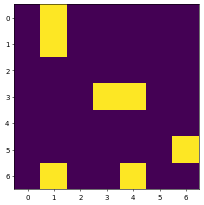

In [24]:
env.render()

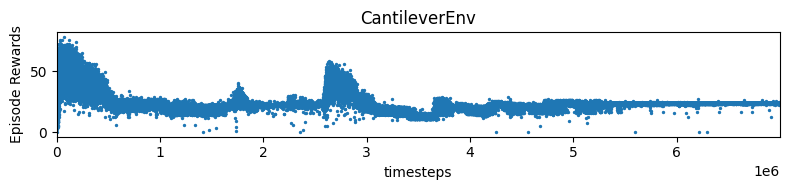

In [25]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [26]:
obs=env.reset()[0]

In [27]:
# Load the agent
model_best = PPO.load(log_dir + "best_model.zip",env=env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [28]:
i=0
while i<1000:
    action, _states = model_best.predict(obs)
    
    obs, rewards, dones, _,info = env.step(int(action))
#     print(env.tmp, env.const)
    if dones:
        break
    i+=1

In [29]:
i

49


Final Cantilever beam design:


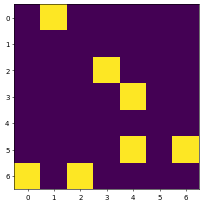

In [30]:
env.render()

In [31]:
# TODO - https://www.sciencedirect.com/science/article/pii/S0264127522002933

# 6 by 6 grid
# different reward 3 
# training ~1.5 hr

# illegal moves reward = -1, terminate ? 

# CNN
# randomize loads 
# utilize symmetry
# reward at the end of episode
# action - remove elements not add 
# refinement 6x6 -> 12x12
# load two elements in inference - test generalizability
# input stress field instead of density field 
# test different RL algorithms 

In [32]:
import random

In [33]:
for j in range(10):
    i=0
    obs=env.reset()
    while i<16*0.68753125:
        action = random.randint(0, 15)

        env.args = get_args(*mbb_beam(rd=env.rd))

        env.M.action_space_(action, env.x)   
        env.tmp, env.const = fast_stopt(env.args, env.x)
        
        i+=1
    print(env.tmp, env.const)    

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.rd to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.rd` for environment variables or `env.get_wrapper_attr('rd')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.M to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.M` for environment variables or `env.get_wrapper_attr('M')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.x to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.x` for

3554154497.8763695 0.16334897959183675
2786952041.5074253 0.16334897959183675
2573819281.6017523 0.18375510204081635
3525730239.232203 0.14294285714285715
2573799957.493164 0.18375510204081635
2759949510.6933613 0.20416122448979596
2785993980.292773 0.16334897959183675
2775713996.194521 0.18375510204081635
5002128406.934273 0.16334897959183675
4868017661.529966 0.20416122448979596


In [34]:
for j in range(10):
    i=0
    obs=env.reset()
    while i<9*0.68753125:
        action = random.randint(0, 8)

        env.args = get_args(*mbb_beam(rd=env.rd))

        env.M.action_space_(action, env.x)   
        env.tmp, env.const = fast_stopt(env.args, env.x)
        
        i+=1
    print(env.tmp, env.const)   

6091338611.919964 0.08172448979591837
3757610819.244991 0.08172448979591837
5645378357.066431 0.06131836734693878
3619851366.629532 0.10213061224489797
6045404346.305725 0.10213061224489797
3774893245.631963 0.08172448979591837
5958827390.230171 0.12253673469387756
4134460559.974284 0.12253673469387756
6054234560.791485 0.10213061224489797
3773648524.6412525 0.10213061224489797
